In [17]:
!pip install catboost
!pip install optuna
!pip install seaborn

In [18]:
import catboost as cb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import optuna
import pandas as pd
from pandas import read_csv

In [19]:
data = read_csv('dataset.csv')

In [20]:
y = data['response_att']
X = data.drop(columns=['response_att'])
X = data.filter(['group', 'perdelta_days_between_visits_15_30d',
 'k_var_days_between_visits_15d',
 'k_var_days_between_visits_1m',
 'k_var_days_between_visits_3m',
 'cheque_count_6m_g41',
 'cheque_count_6m_g40',
 'response_sms',
 'cheque_count_6m_g48',
 'cheque_count_12m_g38',
 'cheque_count_6m_g32',
 'response_viber',
 'k_var_count_per_cheque_6m_g27',
 'cheque_count_6m_g25',
 'cheque_count_12m_g32',
 'k_var_disc_share_15d_g24',
 'k_var_disc_share_6m_g24',
 'food_share_1m',
 'k_var_cheque_3m',
 'cheque_count_6m_g38',
 'cheque_count_3m_g25',
 'age',
 'food_share_15d'])
X.head()

,group,perdelta_days_between_visits_15_30d,k_var_days_between_visits_15d,k_var_days_between_visits_1m,k_var_days_between_visits_3m,cheque_count_6m_g41,cheque_count_6m_g40,response_sms,cheque_count_6m_g48,cheque_count_12m_g38,...,cheque_count_6m_g25,cheque_count_12m_g32,k_var_disc_share_15d_g24,k_var_disc_share_6m_g24,food_share_1m,k_var_cheque_3m,cheque_count_6m_g38,cheque_count_3m_g25,age,food_share_15d
0,1,1.3393,0.4554,0.6479,0.8240,1.0,5.0,0.923077,6.0,8.0,...,9.0,3.0,0.0,0.8036,0.3254,1.8741,4.0,8.0,47.0,0.6488
1,1,0.0000,0.0000,0.0000,1.0027,1.0,3.0,1.000000,1.0,1.0,...,2.0,1.0,0.0,0.0000,1.0000,0.9630,1.0,2.0,57.0,0.0000
2,0,0.0000,0.0000,0.0000,0.5559,8.0,7.0,1.000000,6.0,5.0,...,9.0,4.0,0.0,0.6608,0.4768,0.3295,1.0,3.0,38.0,0.3739
3,1,0.0000,0.0000,0.0000,0.7432,2.0,4.0,0.909091,3.0,14.0,...,11.0,2.0,0.0,0.0000,1.0000,1.4933,5.0,5.0,65.0,0.0000
4,1,0.0000,0.4714,0.4714,0.9980,2.0,8.0,1.000000,4.0,1.0,...,2.0,0.0,0.0,1.0710,0.2882,0.9014,1.0,1.0,61.0,0.2882


In [21]:
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=10)

X_test_0 = X_test.copy()
X_test_0['group'] = np.zeros(len(X_test_0['group']))
X_test_1 = X_test.copy()
X_test_1['group'] = np.ones(len(X_test_1['group']))

In [22]:
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_uniform("colsample_bylevel", 0.005, 0.015),
        "n_estimators": trial.suggest_int("n_estimators", 20, 50),
        "border_count": trial.suggest_int("border_count", 1, 10),
        "depth": trial.suggest_int("depth", 2, 3),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian"]
        ),
        "used_ram_limit": "20gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_uniform("bagging_temperature", 5, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_uniform("subsample", 0.1, 1)

    model = CatBoostClassifier(**param)
    model.fit(X_train, y_train, verbose=False)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=10)
study.best_params

[I 2020-06-27 17:34:49,639] Finished trial#0 with value: 0.8915622316347176 with parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.012016594657844753, 'n_estimators': 20, 'border_count': 6, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.683521561557145}. Best is trial#0 with value: 0.8915622316347176.
[I 2020-06-27 17:34:50,549] Finished trial#1 with value: 0.8915622316347176 with parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.00949842123493162, 'n_estimators': 20, 'border_count': 4, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 9.039984199468517}. Best is trial#0 with value: 0.8915622316347176.
[I 2020-06-27 17:34:53,025] Finished trial#2 with value: 0.8915622316347176 with parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.008405018141301583, 'n_estimators': 42, 'border_count': 7, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'baggi

{'objective': 'CrossEntropy',
 'colsample_bylevel': 0.01317522060231036,
 'n_estimators': 41,
 'border_count': 10,
 'depth': 3,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 6.119058961526154}

In [23]:
model = CatBoostClassifier(
    objective=study.best_params['objective'],
    colsample_bylevel=study.best_params['colsample_bylevel'],
    depth=study.best_params['depth'],
    n_estimators=study.best_params['n_estimators'],
    border_count=study.best_params["border_count"],
    boosting_type=study.best_params['boosting_type'],
    bootstrap_type=study.best_params['bootstrap_type'],
    bagging_temperature=study.best_params['bagging_temperature'])
model.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.4129045	total: 49.2ms	remaining: 1.97s
1:	learn: 0.3580556	total: 98.1ms	remaining: 1.91s
2:	learn: 0.3462735	total: 147ms	remaining: 1.87s
3:	learn: 0.3433123	total: 198ms	remaining: 1.83s
4:	learn: 0.3288737	total: 251ms	remaining: 1.81s
5:	learn: 0.3218028	total: 303ms	remaining: 1.77s
6:	learn: 0.3110968	total: 355ms	remaining: 1.72s
7:	learn: 0.3110670	total: 403ms	remaining: 1.66s
8:	learn: 0.3110596	total: 449ms	remaining: 1.6s
9:	learn: 0.3110578	total: 497ms	remaining: 1.54s
10:	learn: 0.3110573	total: 544ms	remaining: 1.48s
11:	learn: 0.3110573	total: 589ms	remaining: 1.42s
12:	learn: 0.3110573	total: 636ms	remaining: 1.37s
13:	learn: 0.3110573	total: 685ms	remaining: 1.32s
14:	learn: 0.3110573	total: 730ms	remaining: 1.27s
15:	learn: 0.3110573	total: 781ms	remaining: 1.22s
16:	learn: 0.3110573	total: 827ms	remaining: 1.17s
17:	learn: 0.3110573	total: 874ms	remaining: 1.12s
18:	learn: 0.3110573	total: 919ms	remaining: 1.06s
19:	learn: 0.31

In [8]:
model = CatBoostClassifier(
    objective=study.best_params['objective'],
    colsample_bylevel=study.best_params['colsample_bylevel'],
    depth=5,
    n_estimators=100,
    border_count=study.best_params["border_count"],
    boosting_type=study.best_params['boosting_type'],
    bootstrap_type=study.best_params['bootstrap_type'],
    bagging_temperature=5)
model.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.4129045	total: 48.3ms	remaining: 4.79s
1:	learn: 0.3580556	total: 97.9ms	remaining: 4.79s
2:	learn: 0.3462735	total: 147ms	remaining: 4.75s
3:	learn: 0.3435327	total: 194ms	remaining: 4.65s
4:	learn: 0.3290681	total: 246ms	remaining: 4.67s
5:	learn: 0.3208536	total: 299ms	remaining: 4.68s
6:	learn: 0.3208519	total: 346ms	remaining: 4.6s
7:	learn: 0.3208514	total: 393ms	remaining: 4.52s
8:	learn: 0.3208513	total: 440ms	remaining: 4.44s
9:	learn: 0.3208513	total: 485ms	remaining: 4.37s
10:	learn: 0.3208513	total: 533ms	remaining: 4.32s
11:	learn: 0.3208513	total: 578ms	remaining: 4.24s
12:	learn: 0.3208513	total: 623ms	remaining: 4.17s
13:	learn: 0.3208513	total: 671ms	remaining: 4.12s
14:	learn: 0.3208513	total: 716ms	remaining: 4.06s
15:	learn: 0.3208513	total: 763ms	remaining: 4s
16:	learn: 0.3208513	total: 806ms	remaining: 3.94s
17:	learn: 0.3208513	total: 851ms	remaining: 3.88s
18:	learn: 0.3157139	total: 904ms	remaining: 3.85s
19:	learn: 0.31571

In [24]:
X_test['uplift'] = model.predict_proba(X_test_1)[:,1] - model.predict_proba(X_test_0)[:,1]
X_test['response_att'] = y_test

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
def custom_metric(answers, take_top_ratio=0.25):
    answers.sort_values(by='uplift', inplace=True, ascending=False)
    
    n_samples = int(np.ceil(answers.shape[0] * take_top_ratio))
    answers = answers.iloc[:n_samples, :]
    answers_test = answers[answers['group'] == 1]['response_att'].sum() / \
                   answers[answers['group'] == 1].shape[0]
    answers_control = answers[answers['group'] == 0]['response_att'].sum() / \
                      answers[answers['group'] == 0].shape[0]
    return (answers_test - answers_control) * 100

In [26]:
from sklearn.metrics import accuracy_score

print(custom_metric(X_test, take_top_ratio=0.15))
print(custom_metric(X_test, take_top_ratio=0.25))
y_pred = model.predict(X_test)
print(accuracy_score(y_pred, y_test))
#print(np.sum(y_pred) / y_pred.shape[0])
#print(np.sum(y_test) / y_test.shape[0])

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1.242046752303494
0.5392770041290393
0.89030076318841


/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


100


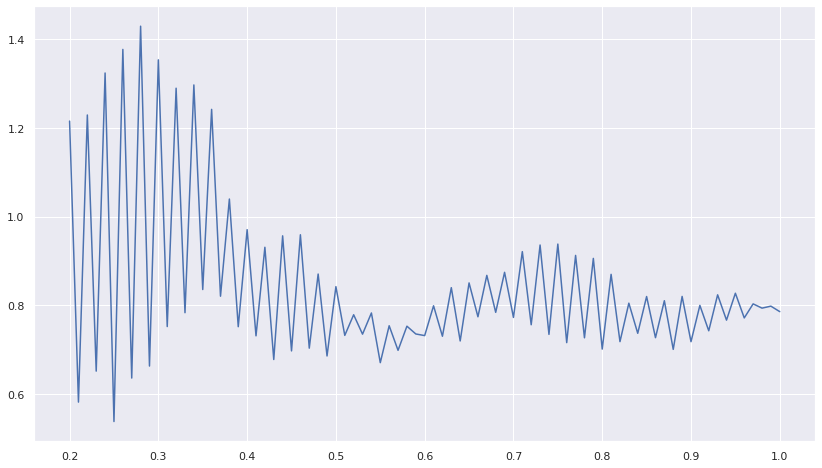

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")
x = []
answers = []
num = 100
for i in range(20, num + 1):
    if i % 100 == 0:
        print(i)
    x.append(1.0 * i / num)
    answers.append(custom_metric(X_test, take_top_ratio=1.0 * i/ num))
    
plt.figure(figsize=(14,8))
plt.plot(x, answers)

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


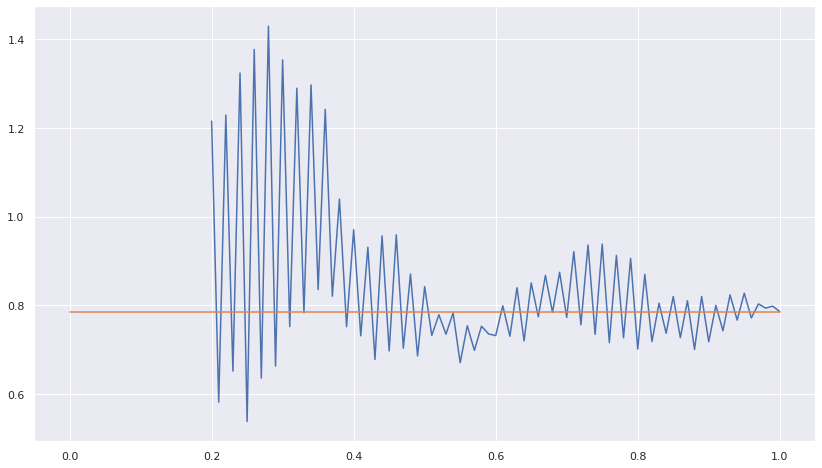

In [16]:
plt.figure(figsize=(14,8))
plt.plot(x, answers)
stupid = custom_metric(X_test, take_top_ratio=1.0)
plt.plot([0, 1], [stupid, stupid])
plt.show()

In [ ]:
import gc
import pandas as pd
import numpy as np
from datetime import datetime

from xgboost import XGBClassifier
from sklift.models import ClassTransformation

from sklift.metrics import uplift_at_k
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
xgb_est_params = {
    'max_depth':2,
    'learning_rate': 0.2, 
    'n_estimators': 100,
    'nthread':40,
    'n_gpus':0,
    'seed':42
}

estimator = XGBClassifier(
    **xgb_est_params
)

uplift_model_cl_tr = ClassTransformation(
    estimator=estimator
)

In [ ]:
uplift_model_cl_tr.fit(
    X=X,
    y=y,
    treatment=df_train_feats['treatment_flg']
)

In [ ]:
df_feat_imp = pd.DataFrame([
    uplift_model_cl_tr\
        .estimator\
        .get_booster()\
        .get_score(importance_type='gain')
        ]
).T.reset_index()

df_feat_imp.columns =\
    ["feature", "value"]
    
df_feat_imp\
    .sort_values('value', ascending=False)